In [1]:
from torch.utils.data import DataLoader

In [2]:
import os
import wandb
import numpy as np
from IPython.display import clear_output
import seaborn as sns
from torchdiffeq import odeint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("GPU Name:", torch.cuda.get_device_name(0))

In [4]:
wandb.login()

True

In [5]:
wandb.init(project="NODE_rnn", group="NODE_rnn",save_code=True,notes="Neural ODE RNN runs and evaluation")

In [6]:
def visualize(real=None, train=None, save=None, title=''):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    
    ax.set_title('Lorenz Attractor \n'+title)

    if train is not None:
      sns.set(style='darkgrid')
      
      z = np.array([o.detach().numpy() for o in train])
      z = np.reshape(z, [-1,3])
      sc = ax.scatter(z[:,0], z[:,1], z[:,2], c=z[:,2], cmap='Greens', s=1)
      #cbar = fig.colorbar(sc)

    if real is not None:
      #sns.set(style='darkgrid')
      
      z = np.array([o.detach().numpy() for o in real])
      z = np.reshape(z, [-1,3])
      ax.scatter(z[:,0], z[:,1], z[:,2], marker='.', color='k', alpha=0.5, linewidths=0, s=45)
      #sc = ax.scatter(z[:,0], z[:,1], z[:,2], c=z[:,2], cmap='Reds', s=1)
      #cbar = fig.colorbar(sc)
      #ax.scatter(, marker='.', c=c,cmap='viridis', alpha=0.5, linewidths=0, s=45)

    fig.canvas.draw()
    fig.canvas.flush_events()
    if save is not None:
        plt.savefig(save+'.png', format='png', dpi=400, bbox_inches ='tight', pad_inches = 0.1)
    plt.show()

In [7]:
def lorenz(t, X):
    sigma = 10.
    beta = 8/3
    rho = 28.
    if X.ndim == 1:
        x, y, z = X
    else:
        x, y, z = X.unbind(dim=-1)
    xdot = sigma * (y - x)
    ydot = x * (rho - z) - y
    zdot = x * y - beta * z
    return torch.stack([xdot, ydot, zdot], dim=-1)

In [8]:
class Lorenz(nn.Module):
    """
    chaotic lorenz system
    """
    def __init__(self):
        super(Lorenz, self).__init__()
        self.lin = nn.Linear(5, 3, bias=False)
        W = torch.tensor([[-10., 10., 0., 0., 0.],
                          [28., -1., 0., -1., 0.],
                          [0., 0., -8. / 3., 0., 1.]])
        self.lin.weight = nn.Parameter(W)

    def forward(self, t, x):
        y = y = torch.ones([1, 5])
        y[0][0] = x[0][0]
        y[0][1] = x[0][1]
        y[0][2] = x[0][2]
        y[0][3] = x[0][0] * x[0][2]
        y[0][4] = x[0][0] * x[0][1]
        return self.lin(y)

true_y0 = torch.tensor([[0.5, 0.5, 20.]])  # initial condition
t = torch.linspace(0., 10., 5000)  # t is from 0 to 25 for 1000 data points

# generating training data
with torch.no_grad():
    data = odeint(Lorenz(), true_y0, t)

visualize(real=data)

In [9]:
data.shape

torch.Size([5000, 1, 3])

In [10]:
wandb_config = {
    'hidden_size': 512,
    'learning_rate': 1e-2,
    'batch_size': 50,
    'max_iterations': 1000,
}

# Initialize wandb configuration
wandb.config.update(wandb_config)

In [11]:
#sweep_id = wandb.sweep(sweep_path="sweep.yaml", project="NODE_rnn")

In [12]:
class LorenzTrain(nn.Module):
    """
    neural network for learning the chaotic lorenz system
    """
    def __init__(self):
        super(LorenzTrain, self).__init__()
        self.lin = nn.Linear(3, 512)
        self.lin3 = nn.Linear(512, 3)
        self.relu = nn.ReLU()

    def forward(self, t, x):
        x = self.relu(self.lin(x))
        x = self.lin3(x)
        return x
     

In [13]:
def get_batch(true_y, batch_size):
    num_samples = len(true_y)
    indices = np.random.choice(np.arange(num_samples - batch_size, dtype=np.int64), size=batch_size, replace=False)
    indices.sort()
    batch_y0 = true_y[indices]  # (batch_size, D)
    batch_t = t[:batch_size]  # (batch_size)
    batch_y = torch.stack([true_y[indices + i] for i in range(batch_size)], dim=0)  # (batch_size, M, D)
    return batch_y0, batch_t, batch_y

In [14]:
np.random.seed(7)

In [15]:

func = LorenzTrain().to(device)  # initializing Neural ODE
visualizer = visualize
optimizer = optim.Adam(func.parameters(), lr=1e-2)

In [16]:
data = data.to(device)

In [17]:
t = t.to(device)

In [18]:
#os.makedirs("PNG")

In [19]:
data[0]

tensor([[ 0.5000,  0.5000, 20.0000]], device='cuda:0')

In [20]:
losses = []
whole_losses = []
best_loss = 1.0
for itr in range(1, 3000 + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(data,50)  # getting trajectory batch
    pred_y = odeint(func, batch_y0, batch_t)  # prediction using batch initial condition and batch time stamps
    loss = F.mse_loss(pred_y, batch_y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(func.state_dict(), 'saved_models/lorenz_node.pth')
    if itr % 40 == 0:
        if itr > 1800:
            optimizer.param_groups[0]['lr'] = 1e-3
        with torch.no_grad():
            pred_y = odeint(func, data[0], t)
            loss = F.mse_loss(pred_y, data)
            whole_losses.append(loss.item())
            visualize(real=data.cpu(), 
                             train=pred_y.cpu())

            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            clear_output(wait=True)

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imageio

def visualize(real=None, train=None, save=None, title='', fps=10):
    frames = []  # List to store frames

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    ax.set_title('Lorenz Attractor \n' + title)

    for i in range(len(train) if train is not None else len(real)):
        ax.cla()

        if train is not None:
            z = np.array([o.detach().numpy() for o in train])
            z = np.reshape(z, [-1, 3])
            sc = ax.scatter(z[:, 0], z[:, 1], z[:, 2], c=z[:, 2], cmap='Greens', s=1)

        if real is not None:
            z = np.array([o.detach().numpy() for o in real])
            z = np.reshape(z, [-1, 3])
            ax.scatter(z[:, 0], z[:, 1], z[:, 2], marker='.', color='k', alpha=0.5, linewidths=0, s=45)

        fig.canvas.draw()
        frame = np.fromstring(fig.canvas.tostring_rgb(), dtype='uint8', sep='')
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)

    if save is not None:
        imageio.mimsave(save + '.gif', frames, fps=fps)

    plt.close(fig)

In [22]:
from torch.utils.data import DataLoader

In [23]:
import os
import wandb
import numpy as np
from IPython.display import clear_output
import seaborn as sns
from torchdiffeq import odeint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("GPU Name:", torch.cuda.get_device_name(0))

In [25]:
wandb.login()

True

In [26]:
wandb.init(project="NODE_rnn", group="NODE_rnn",save_code=True,notes="Neural ODE RNN runs and evaluation")

In [27]:
# def visualize(real=None, train=None, save=None, title=''):
#     fig = plt.figure(figsize=(10,10))
#     ax = fig.add_subplot(1, 1, 1, projection='3d')
    
#     ax.set_title('Lorenz Attractor \n'+title)

#     if train is not None:
#       sns.set(style='darkgrid')
      
#       z = np.array([o.detach().numpy() for o in train])
#       z = np.reshape(z, [-1,3])
#       sc = ax.scatter(z[:,0], z[:,1], z[:,2], c=z[:,2], cmap='Greens', s=1)
#       #cbar = fig.colorbar(sc)

#     if real is not None:
#       #sns.set(style='darkgrid')
      
#       z = np.array([o.detach().numpy() for o in real])
#       z = np.reshape(z, [-1,3])
#       ax.scatter(z[:,0], z[:,1], z[:,2], marker='.', color='k', alpha=0.5, linewidths=0, s=45)
#       #sc = ax.scatter(z[:,0], z[:,1], z[:,2], c=z[:,2], cmap='Reds', s=1)
#       #cbar = fig.colorbar(sc)
#       #ax.scatter(, marker='.', c=c,cmap='viridis', alpha=0.5, linewidths=0, s=45)

#     fig.canvas.draw()
#     fig.canvas.flush_events()
#     if save is not None:
#         plt.savefig(save+'.png', format='png', dpi=400, bbox_inches ='tight', pad_inches = 0.1)
#     plt.show()

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imageio

def visualize(real=None, train=None, save=None, title='', fps=10):
    frames = []  # List to store frames

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    ax.set_title('Lorenz Attractor \n' + title)

    for i in range(len(train) if train is not None else len(real)):
        ax.cla()

        if train is not None:
            z = np.array([o.detach().numpy() for o in train])
            z = np.reshape(z, [-1, 3])
            sc = ax.scatter(z[:, 0], z[:, 1], z[:, 2], c=z[:, 2], cmap='Greens', s=1)

        if real is not None:
            z = np.array([o.detach().numpy() for o in real])
            z = np.reshape(z, [-1, 3])
            ax.scatter(z[:, 0], z[:, 1], z[:, 2], marker='.', color='k', alpha=0.5, linewidths=0, s=45)

        fig.canvas.draw()
        frame = np.fromstring(fig.canvas.tostring_rgb(), dtype='uint8', sep='')
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)

    if save is not None:
        imageio.mimsave(save + '.gif', frames, fps=fps)

    plt.close(fig)

In [29]:
def lorenz(t, X):
    sigma = 10.
    beta = 8/3
    rho = 28.
    if X.ndim == 1:
        x, y, z = X
    else:
        x, y, z = X.unbind(dim=-1)
    xdot = sigma * (y - x)
    ydot = x * (rho - z) - y
    zdot = x * y - beta * z
    return torch.stack([xdot, ydot, zdot], dim=-1)

In [30]:
class Lorenz(nn.Module):
    """
    chaotic lorenz system
    """
    def __init__(self):
        super(Lorenz, self).__init__()
        self.lin = nn.Linear(5, 3, bias=False)
        W = torch.tensor([[-10., 10., 0., 0., 0.],
                          [28., -1., 0., -1., 0.],
                          [0., 0., -8. / 3., 0., 1.]])
        self.lin.weight = nn.Parameter(W)

    def forward(self, t, x):
        y = y = torch.ones([1, 5])
        y[0][0] = x[0][0]
        y[0][1] = x[0][1]
        y[0][2] = x[0][2]
        y[0][3] = x[0][0] * x[0][2]
        y[0][4] = x[0][0] * x[0][1]
        return self.lin(y)

true_y0 = torch.tensor([[0.5, 0.5, 20.]])  # initial condition
t = torch.linspace(0., 10., 5000)  # t is from 0 to 25 for 1000 data points

# generating training data
with torch.no_grad():
    data = odeint(Lorenz(), true_y0, t)

visualize(real=data)

In [31]:
from torch.utils.data import DataLoader

In [32]:
import os
import wandb
import numpy as np
from IPython.display import clear_output
import seaborn as sns
from torchdiffeq import odeint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("GPU Name:", torch.cuda.get_device_name(0))

In [34]:
wandb.login()

True

In [35]:
wandb.init(project="NODE_rnn", group="NODE_rnn",save_code=True,notes="Neural ODE RNN runs and evaluation")

In [36]:
# def visualize(real=None, train=None, save=None, title=''):
#     fig = plt.figure(figsize=(10,10))
#     ax = fig.add_subplot(1, 1, 1, projection='3d')
    
#     ax.set_title('Lorenz Attractor \n'+title)

#     if train is not None:
#       sns.set(style='darkgrid')
      
#       z = np.array([o.detach().numpy() for o in train])
#       z = np.reshape(z, [-1,3])
#       sc = ax.scatter(z[:,0], z[:,1], z[:,2], c=z[:,2], cmap='Greens', s=1)
#       #cbar = fig.colorbar(sc)

#     if real is not None:
#       #sns.set(style='darkgrid')
      
#       z = np.array([o.detach().numpy() for o in real])
#       z = np.reshape(z, [-1,3])
#       ax.scatter(z[:,0], z[:,1], z[:,2], marker='.', color='k', alpha=0.5, linewidths=0, s=45)
#       #sc = ax.scatter(z[:,0], z[:,1], z[:,2], c=z[:,2], cmap='Reds', s=1)
#       #cbar = fig.colorbar(sc)
#       #ax.scatter(, marker='.', c=c,cmap='viridis', alpha=0.5, linewidths=0, s=45)

#     fig.canvas.draw()
#     fig.canvas.flush_events()
#     if save is not None:
#         plt.savefig(save+'.png', format='png', dpi=400, bbox_inches ='tight', pad_inches = 0.1)
#     plt.show()

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imageio

def visualize(real=None, train=None, save=None, title='', fps=10):
    frames = []  # List to store frames

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    ax.set_title('Lorenz Attractor \n' + title)

    for i in range(len(train) if train is not None else len(real)):
        ax.cla()

        if train is not None:
            z = np.array([o.detach().numpy() for o in train])
            z = np.reshape(z, [-1, 3])
            sc = ax.scatter(z[:, 0], z[:, 1], z[:, 2], c=z[:, 2], cmap='Greens', s=1)

        if real is not None:
            z = np.array([o.detach().numpy() for o in real])
            z = np.reshape(z, [-1, 3])
            ax.scatter(z[:, 0], z[:, 1], z[:, 2], marker='.', color='k', alpha=0.5, linewidths=0, s=45)

        fig.canvas.draw()
        frame = np.fromstring(fig.canvas.tostring_rgb(), dtype='uint8', sep='')
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)

    if save is not None:
        imageio.mimsave(save + '.gif', frames, fps=fps)

    plt.close(fig)

In [38]:
def lorenz(t, X):
    sigma = 10.
    beta = 8/3
    rho = 28.
    if X.ndim == 1:
        x, y, z = X
    else:
        x, y, z = X.unbind(dim=-1)
    xdot = sigma * (y - x)
    ydot = x * (rho - z) - y
    zdot = x * y - beta * z
    return torch.stack([xdot, ydot, zdot], dim=-1)

In [39]:
class Lorenz(nn.Module):
    """
    chaotic lorenz system
    """
    def __init__(self):
        super(Lorenz, self).__init__()
        self.lin = nn.Linear(5, 3, bias=False)
        W = torch.tensor([[-10., 10., 0., 0., 0.],
                          [28., -1., 0., -1., 0.],
                          [0., 0., -8. / 3., 0., 1.]])
        self.lin.weight = nn.Parameter(W)

    def forward(self, t, x):
        y = y = torch.ones([1, 5])
        y[0][0] = x[0][0]
        y[0][1] = x[0][1]
        y[0][2] = x[0][2]
        y[0][3] = x[0][0] * x[0][2]
        y[0][4] = x[0][0] * x[0][1]
        return self.lin(y)

true_y0 = torch.tensor([[0.5, 0.5, 20.]])  # initial condition
t = torch.linspace(0., 10., 5000)  # t is from 0 to 25 for 1000 data points

# generating training data
with torch.no_grad():
    data = odeint(Lorenz(), true_y0, t)

visualize(real=data,save='real',title='Real Data')

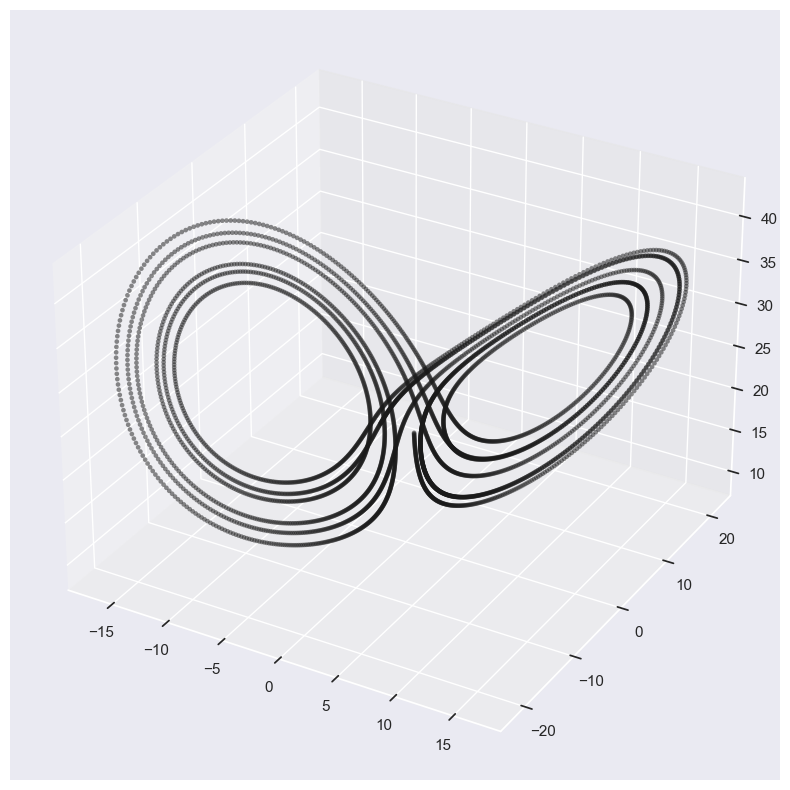

In [40]:
from torch.utils.data import DataLoader

In [41]:
import os
import wandb
import numpy as np
from IPython.display import clear_output
import seaborn as sns
from torchdiffeq import odeint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("GPU Name:", torch.cuda.get_device_name(0))

In [43]:
wandb.login()

True

In [44]:
wandb.init(project="NODE_rnn", group="NODE_rnn",save_code=True,notes="Neural ODE RNN runs and evaluation")